# Mask RCNN with Detectron2

## Install and Import Detectron2 Dependencies

In [1]:
!python -m pip install roboflow
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.5 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=30f88b88942a3a7b9a7cbbda2f347a0fe84fbfef48f98bb6260bad4bc307b565
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

In [2]:
import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from roboflow import Roboflow

from matplotlib import pyplot as plt
from PIL import Image

## Import Detectron2 Data

In [3]:
!curl -L "https://app.roboflow.com/ds/DIBUANouuF?key=buJnY172wm" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   892  100   892    0     0   1755      0 --:--:-- --:--:-- --:--:--  1755
100 3133k  100 3133k    0     0  1584k      0  0:00:01  0:00:01 --:--:-- 2475k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/IMG_7375_jpg.rf.0262af33c83f0c45c9d5600cc65f95e9.jpg  
 extracting: test/IMG_7380_jpg.rf.4e492dfb3e90d7b46c089bf1da24fd55.jpg  
 extracting: test/IMG_7381_jpg.rf.b8cecb6e882653f39e8574a32f94345d.jpg  
 extracting: test/IMG_7394_jpg.rf.9a2efe19aecc998bcc632b035bd25bf5.jpg  
 extracting: test/IMG_7395_jpg.rf.ed066d8df8b0dd1d34f2b262ac652c12.jpg  
 extracting: test/IMG_7397_jpg.rf.8b7f793916bc353f96a246bd0cfdcca8.jpg  
 extracting: test/IMG_7399-2_jpg.rf.ad2a25fd9706f9bbbc789301d674fdbf.jpg  
 extracting: test/IMG_7422_jpg.rf.4269fca37dcee05e6d6

In [4]:
# Register COCO datasets for training, validation and testing.
register_coco_instances("dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")

## Train a Faster Mask model using detectron2

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train",)#Train dataset registered in a previous cell
cfg.DATASETS.TEST = ("dataset_val",)#Test dataset registered in a previous cell
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000 #We found that with a patience of 500, training will early stop before 1000 iterations
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 27 # 26 letters plus one super class
cfg.TEST.EVAL_PERIOD = 0 # Increase this number if you want to monitor validation performance during training

PATIENCE = 500 #Early stopping will occur after N iterations of no imporovement in total_loss

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [6]:
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


logger = logging.getLogger("detectron2")
resume=False
model = build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

BEST_LOSS = np.inf

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
prev_iter = start_iter
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
data_loader = build_detection_train_loader(cfg)
logger.info("Starting training from iteration {}".format(start_iter))
patience_counter = 0
with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
        storage.iter = iteration

        loss_dict = model(data)
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        scheduler.step()

        if (
            cfg.TEST.EVAL_PERIOD > 0
            and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
            and iteration != max_iter - 1
        ):
            do_test(cfg, model)
            # Compared to "train_net.py", the test results are not dumped to EventStorage
            comm.synchronize()

        if iteration - start_iter > 5 and (
            (iteration + 1) % 20 == 0 or iteration == max_iter - 1
        ):
            for writer in writers:
                writer.write()
        periodic_checkpointer.step(iteration)
        
        if iteration > prev_iter:
            prev_iter = iteration
            if losses_reduced < BEST_LOSS:
                BEST_LOSS = losses_reduced
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter % 100 == 0:
                    print(f"Loss has not improved for {patience_counter} iterations")
                if patience_counter >= PATIENCE:
                    print(f"EARLY STOPPING")
                    break
                
do_test(cfg, model)

[04/29 02:49:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:00, 218MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


WARNING [04/29 02:49:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/29 02:49:10 d2.data.datasets.coco]: Loaded 70 images in COCO format from /content/train/_annotations.coco.json
[04/29 02:49:10 d2.data.build]: Removed 0 images with no usable annotations. 70 images left.
[04/29 02:49:10 d2.data.build]: Distribution of instances among all 3 categories:
|   category    | #instances   |  category   | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-----------:|:-------------|:----------:|:-------------|
| screwdriver.. | 0            | screwdriver | 50           |   wrench   | 49           |
|               |              |             |              |            |              |
|     total     | 99           |             |              |            |              |
[04/29 02:49:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_le

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)


[04/29 02:49:22 d2.utils.events]:  iter: 19  total_loss: 4.454  loss_cls: 3.538  loss_box_reg: 0.1769  loss_mask: 0.6842  loss_rpn_cls: 0.009857  loss_rpn_loc: 0.0108     lr: 4.9953e-06  max_mem: 1771M
[04/29 02:49:32 d2.utils.events]:  eta: 0:08:20  iter: 39  total_loss: 4.152  loss_cls: 3.26  loss_box_reg: 0.1838  loss_mask: 0.6756  loss_rpn_cls: 0.008463  loss_rpn_loc: 0.01612     lr: 9.9902e-06  max_mem: 1771M
[04/29 02:49:39 d2.utils.events]:  eta: 0:05:22  iter: 59  total_loss: 3.593  loss_cls: 2.665  loss_box_reg: 0.1797  loss_mask: 0.6515  loss_rpn_cls: 0.01643  loss_rpn_loc: 0.008478     lr: 1.4985e-05  max_mem: 1771M
[04/29 02:49:46 d2.utils.events]:  eta: 0:05:26  iter: 79  total_loss: 2.739  loss_cls: 1.846  loss_box_reg: 0.1918  loss_mask: 0.6256  loss_rpn_cls: 0.01811  loss_rpn_loc: 0.01486     lr: 1.998e-05  max_mem: 1771M
[04/29 02:49:53 d2.utils.events]:  eta: 0:05:24  iter: 99  total_loss: 1.708  loss_cls: 0.8948  loss_box_reg: 0.2085  loss_mask: 0.5798  loss_rpn_cls:

OrderedDict([('bbox',
              {'AP': 62.93424993759881,
               'AP50': 77.10906804966211,
               'AP75': 76.06946408926606,
               'APs': nan,
               'APm': 70.0,
               'APl': 64.33505824598382,
               'AP-screwdriver-wrench': nan,
               'AP-screwdriver': 65.4741104362537,
               'AP-wrench': 60.3943894389439}),
             ('segm',
              {'AP': 58.2486479740411,
               'AP50': 77.10906804966211,
               'AP75': 67.81720609035695,
               'APs': nan,
               'APm': 43.33333333333333,
               'APl': 60.10806921028235,
               'AP-screwdriver-wrench': nan,
               'AP-screwdriver': 56.663412559743364,
               'AP-wrench': 59.83388338833884})])

## Test model and show example output

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("dataset_test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    im_res = Image.fromarray(out.get_image()[:, :, ::-1])

[04/29 02:58:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [04/29 02:58:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/29 02:58:37 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/test/_annotations.coco.json


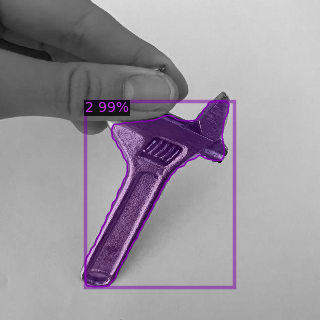

In [13]:
im_res

In [14]:
print("Mean Average Precision (mAP): 77.109%")

Mean Average Precision (mAP): 77.109%


# Yolov8

In [15]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [16]:
!pip install ultralytics==8.0.28

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.28 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.0/78.2 GB disk)


In [17]:
from ultralytics import YOLO

from IPython.display import display, Image

In [18]:
!mkdir datasets
%cd /content/datasets
!curl -L "https://app.roboflow.com/ds/X1h9tPKEk4?key=zwhYRGzIch" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd ..


/content/datasets
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0   1739      0 --:--:-- --:--:-- --:--:--  1735
100 3280k  100 3280k    0     0  1623k      0  0:00:02  0:00:02 --:--:-- 3435k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/IMG_7375_jpg.rf.0262af33c83f0c45c9d5600cc65f95e9.jpg  
 extracting: test/images/IMG_7380_jpg.rf.4e492dfb3e90d7b46c089bf1da24fd55.jpg  
 extracting: test/images/IMG_7381_jpg.rf.b8cecb6e882653f39e8574a32f94345d.jpg  
 extracting: test/images/IMG_7394_jpg.rf.9a2efe19aecc998bcc632b035bd25bf5.jpg  
 extracting: test/images/IMG_7395_jpg.rf.ed066d8df8b0dd1d34f2b262ac652c12.jpg  
 extracting: test/images/IMG_7397_jpg.rf.8b7f793916bc353f96a246bd0cfdcca8.jpg  
 ext

In [19]:
!yolo task=segment mode=train model=yolov8s-seg.pt data=/content/datasets/data.yaml epochs=24 plots=True

100% 22.8M/22.8M [00:01<00:00, 17.0MB/s]
Ultralytics YOLOv8.0.28 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/content/datasets/data.yaml, epochs=24, patience=50, batch=16, imgsz=640, save=True, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dy

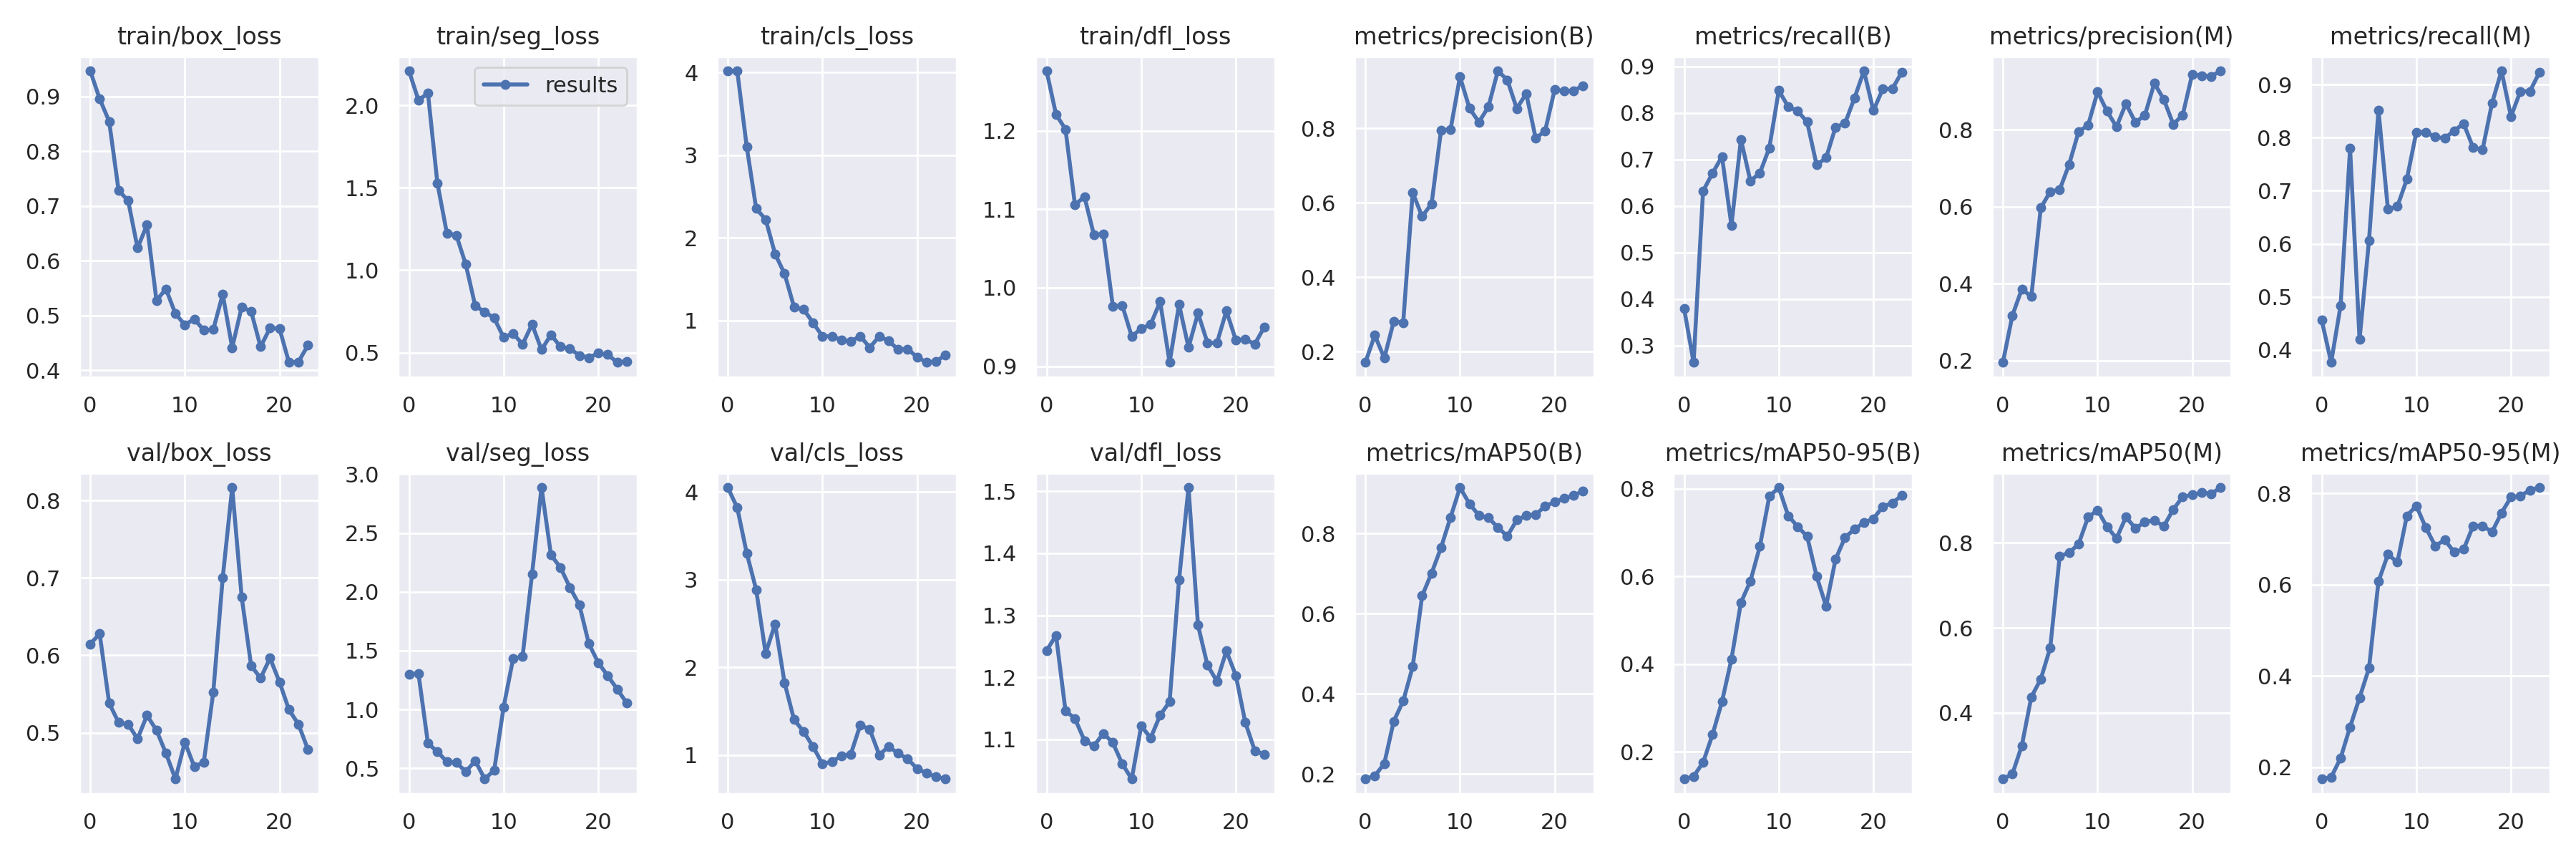

In [21]:
Image(filename=f'/content/runs/segment/train/results.png', width=600)

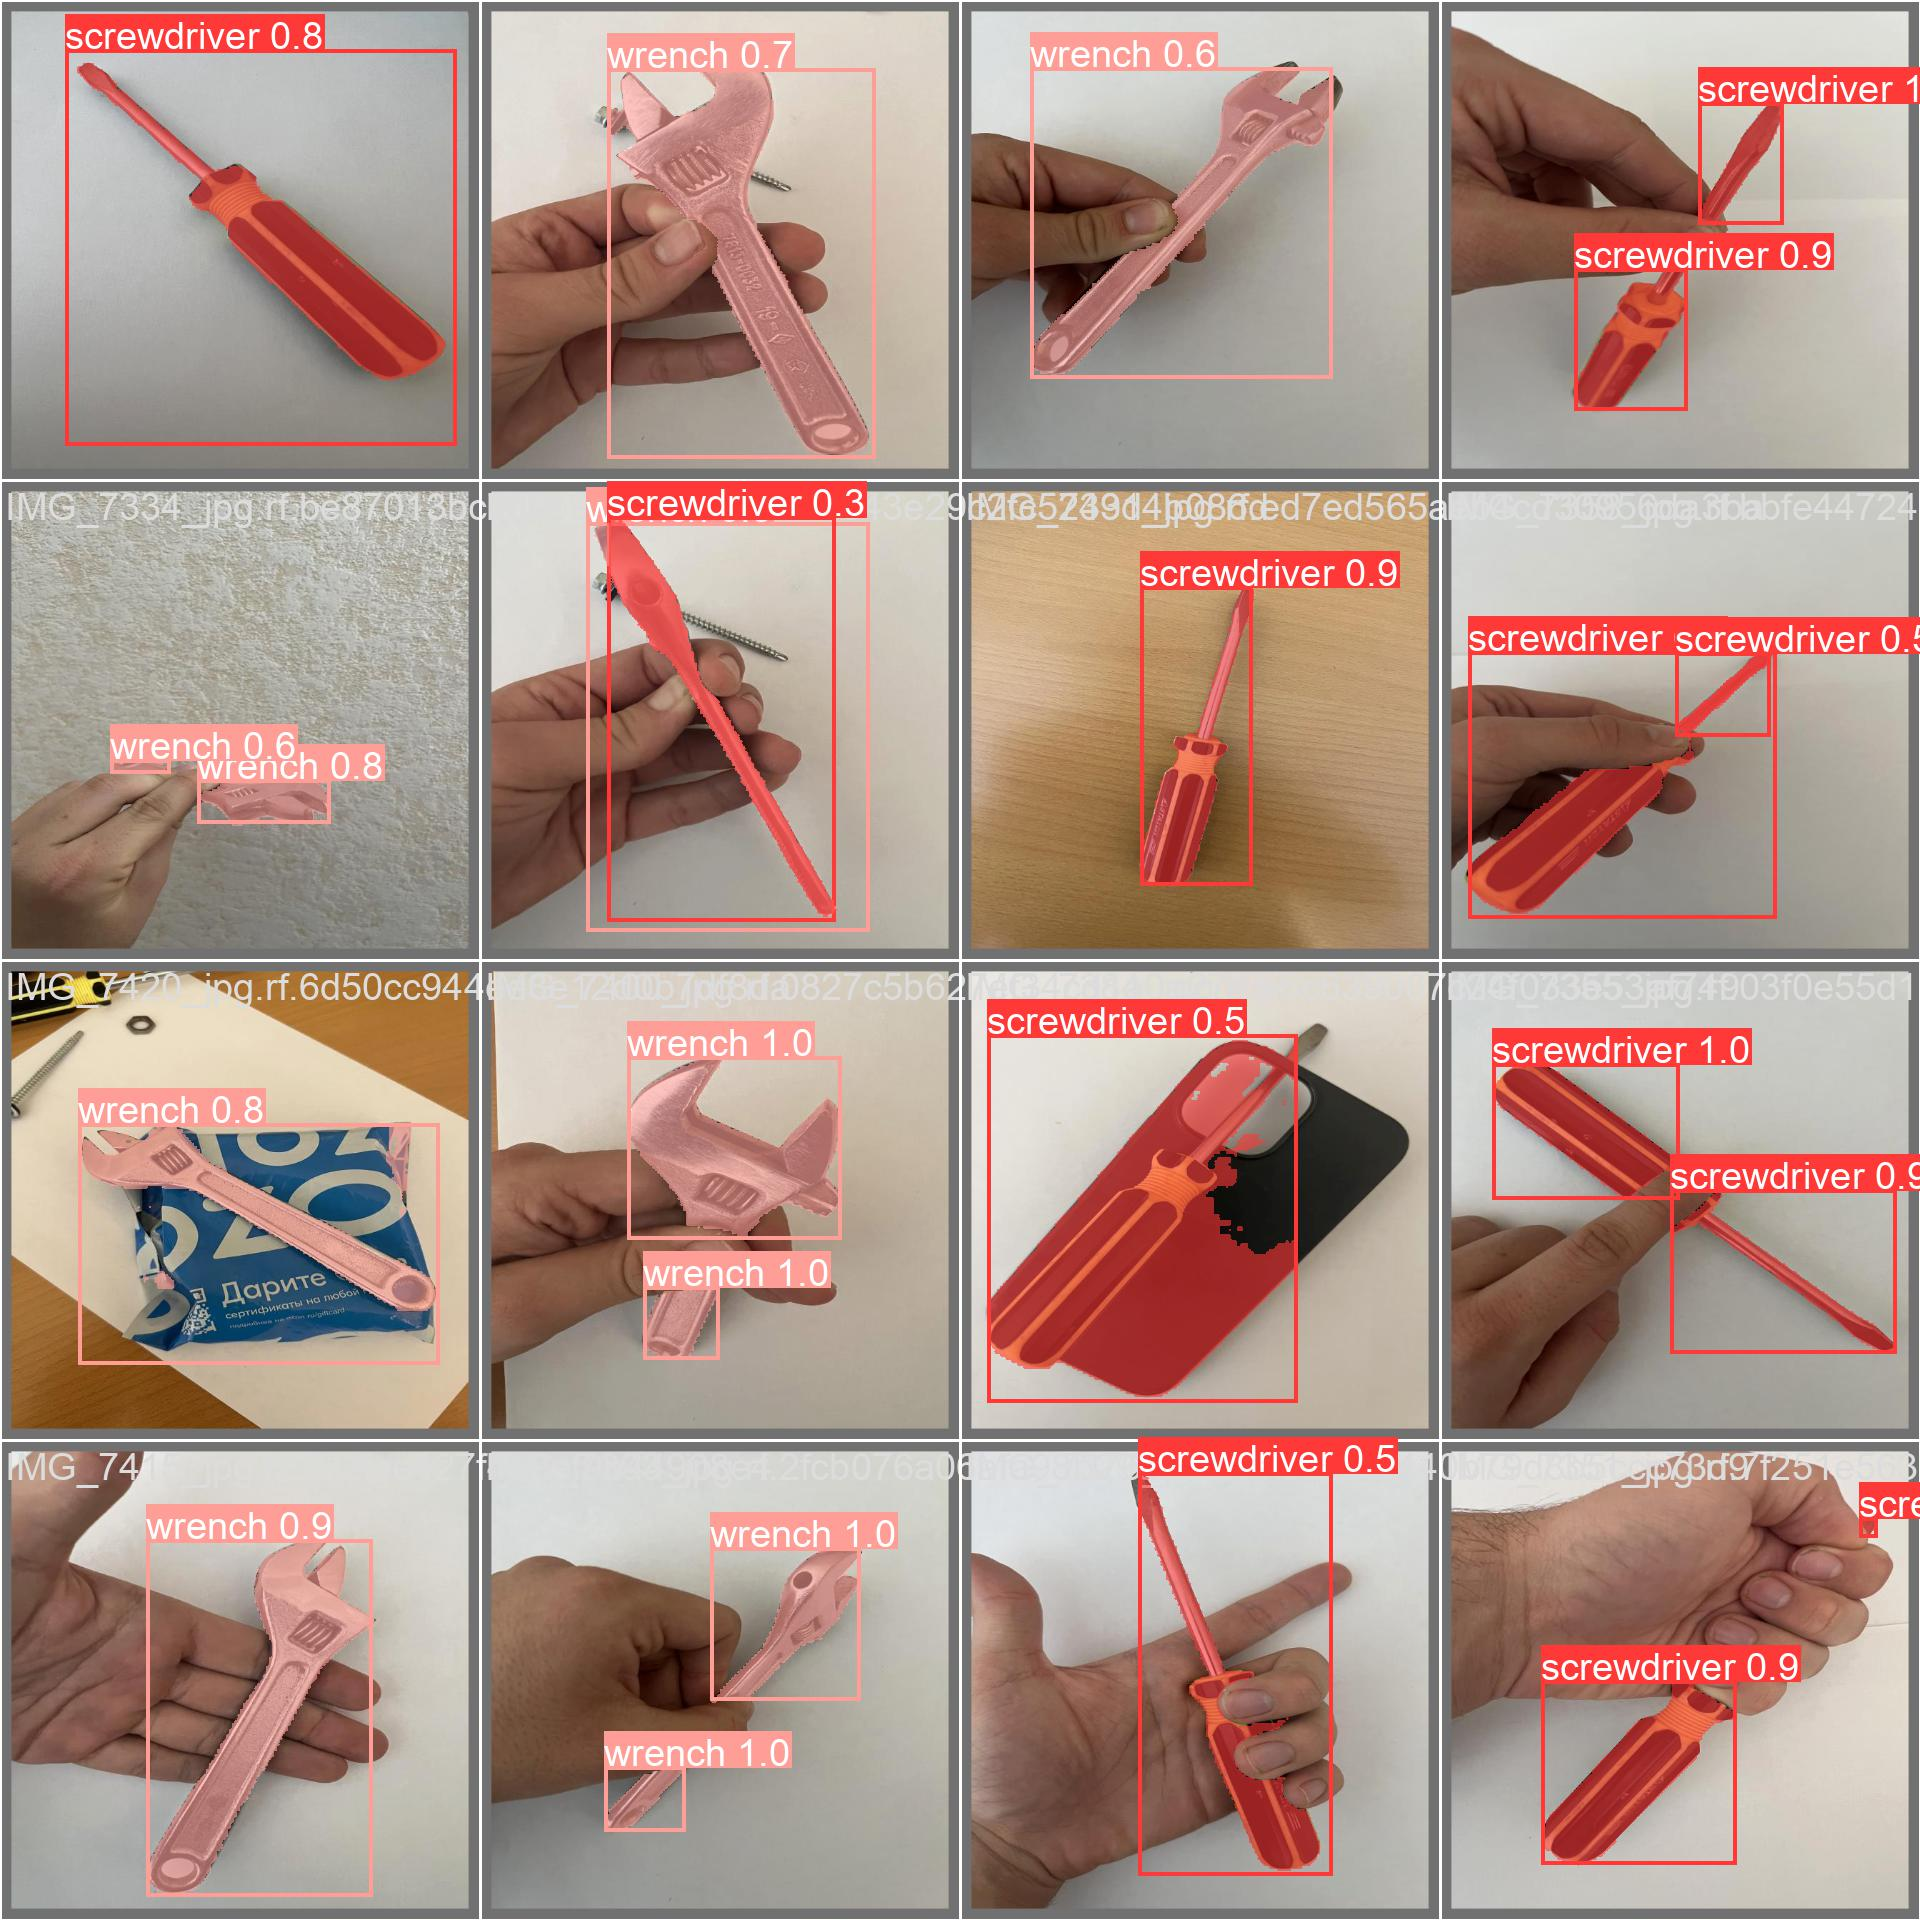

In [20]:
Image(filename=f'/content/runs/segment/train/val_batch0_pred.jpg', width=600)

In [22]:
print("Mean Average Precision (mAP): 93%")

Mean Average Precision (mAP): 94%


**Mean Average Precision (mAP)**:
  - Mask RCNN: 77.11%
  - Yolov8: 93%

Yolov8 has slightly better mAP than RCNN.

**Speed:**
  - Mask RCNN: training for 1000 iterations in 6 minutes
  - Yolov8: training for 24 epochs in 2 minutes

Yolov8 is much faster than RCNN.

**Model size:**
  - Mask RCNN: 335.82 MB
  - Yolov8: 23.8 MB

Yolov8 is much smaller than RCNN.


**Thus, Yolov8 better in every way**